# Using the Amazon Rekognition API 

This notebook you will ue the object and celebrity detection, content moderation, text detection, face detection, and face collections Amazon Rekognition API's.

***
This notebook provides a walkthrough of the different [ API's]() in Amazon Rekognition to identify objects, celebrities, faces, content, and text.  This notebook utilizes the Python [ Boto3 SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html).
***

# Initialize SageMaker Notebook Environment

In [63]:
# Initialise Notebook
# Import the AWS boto3 Python SDK
import time
import os
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont


In [2]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

In [3]:
# Init clients
rekognition = boto3.client('rekognition')
s3 = boto3.client('s3')

In [4]:
# S3 bucket that contains sample images and videos

# We are providing sample images and videos in this bucket so
# you do not have to manually download/upload test images and videos.

bucketName = "m2c-gps304-workshop-" + awsRegion

In [5]:
# Create temporary directory
# This directory is not needed to call Rekognition APIs.
# We will only use this directory to download images from S3 bucket and draw bounding boxes

!mkdir temp
tempFolder = 'temp/'

mkdir: temp: File exists


# Detect objects in image
***

### Set the image that you will use to call the detect images Rekognition API.

In [6]:
imageName = "media/object-detection/cars.png"

### View the image that will be submitted to the detect images Rekognition API

In [7]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

#### Call Rekognition to detect objects in the image

In [8]:
# Call Amazon Rekognition to detect objects in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html

detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

#### Review the raw JSON reponse from Rekognition

In [62]:
# Show JSON response returned by Rekognition Labels API (Object Detection)
# In the JSON response below, you will see Label, detected instances, confidence score and additional information.

display(detectLabelsResponse)

{'Labels': [{'Name': 'Car',
   'Confidence': 99.87421417236328,
   'Instances': [{'BoundingBox': {'Width': 0.24012896418571472,
      'Height': 0.1800784170627594,
      'Left': 0.1865045726299286,
      'Top': 0.5646552443504333},
     'Confidence': 99.87421417236328},
    {'BoundingBox': {'Width': 0.21805639564990997,
      'Height': 0.1281619518995285,
      'Left': 0.5005310773849487,
      'Top': 0.5910496115684509},
     'Confidence': 99.79024505615234},
    {'BoundingBox': {'Width': 0.061916351318359375,
      'Height': 0.1096307560801506,
      'Left': 0.3761284351348877,
      'Top': 0.6118627786636353},
     'Confidence': 80.46967315673828}],
   'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]},
  {'Name': 'Automobile',
   'Confidence': 99.87421417236328,
   'Instances': [],
   'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]},
  {'Name': 'Vehicle',
   'Confidence': 99.87421417236328,
   'Instances': [],
   'Parents': [{'Name': 'Transportation'}]},
  {

### Display list of labels detected

In [10]:
for label in detectLabelsResponse["Labels"]:
    print("- {} (Confidence: {})".format(label["Name"], label["Confidence"]))

- Car (Confidence: 99.87421417236328)
- Automobile (Confidence: 99.87421417236328)
- Vehicle (Confidence: 99.87421417236328)
- Transportation (Confidence: 99.87421417236328)
- Tire (Confidence: 99.29731750488281)
- Spoke (Confidence: 99.17047119140625)
- Machine (Confidence: 99.17047119140625)
- Wheel (Confidence: 98.75944519042969)
- Alloy Wheel (Confidence: 98.0056381225586)
- Car Wheel (Confidence: 97.0373764038086)
- Sports Car (Confidence: 96.17302703857422)
- Race Car (Confidence: 81.01554870605469)
- Coupe (Confidence: 79.94200897216797)


# Recognize celebrities in image
***

### Set the image to be used

In [12]:
imageName = "media/celebrity-recognition/GrandTourjc.png"

#### Call Rekognition to recognize celebrities in the image

In [13]:
# Call Amazon Rekognition to recognize celebrities in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_RecognizeCelebrities.html

recognizeCelebritiesResponse = rekognition.recognize_celebrities(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

#### Review raw JSON reponse from Rekognition

In [14]:
# Show JSON response returned by Rekognition Celebrity Recognition API
# In the JSON response below, you will see CelebrityFaces which contains information about recognized celebrities.
# For each recognized celebrity, you will see information like Name, Id, Urls and additional information about 
# their facial attributes.

display(recognizeCelebritiesResponse)

{'CelebrityFaces': [{'Urls': ['www.wikidata.org/wiki/Q216160',
    'www.imdb.com/name/nm0165087'],
   'Name': 'Jeremy Clarkson',
   'Id': '2mW0ey5n',
   'Face': {'BoundingBox': {'Width': 0.0743597224354744,
     'Height': 0.19009648263454437,
     'Left': 0.45298805832862854,
     'Top': 0.16235747933387756},
    'Confidence': 99.99576568603516,
    'Landmarks': [{'Type': 'mouthRight',
      'X': 0.48697322607040405,
      'Y': 0.3041914701461792},
     {'Type': 'eyeLeft', 'X': 0.466238409280777, 'Y': 0.23679687082767487},
     {'Type': 'nose', 'X': 0.46289438009262085, 'Y': 0.2702392339706421},
     {'Type': 'mouthLeft', 'X': 0.46718135476112366, 'Y': 0.3023645579814911},
     {'Type': 'eyeRight', 'X': 0.4902404248714447, 'Y': 0.2384326457977295}],
    'Pose': {'Roll': -0.1918155997991562,
     'Yaw': -43.80965042114258,
     'Pitch': 1.3805574178695679},
    'Quality': {'Brightness': 54.28943634033203,
     'Sharpness': 26.1773681640625},
    'Emotions': [{'Type': 'CALM', 'Confidence

### Review celebreties detected

In [15]:
for celibrity in recognizeCelebritiesResponse["CelebrityFaces"]:
    print("- {} (Confidence: {})".format(celibrity["Name"], celibrity["Confidence"]))

KeyError: 'Confidence'

#### Show image with bounding boxes around recognized celebrities

In [16]:
# Define a function that will display image with bounded boxes around recognized celebrites
# We will call this function in next step
  
def drawBoundingBoxes (sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255,255,255),(255,255,255),(76,182,252),(52,194,123))
    
    # Download image locally
    imageLocation = tempFolder+os.path.basename(sourceImage)
    s3.download_file(bucketName, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        draw.text((x1,y1),box[0],colors[col])
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
        imageFormat = 'JPEG'

    bbImage.save(imageLocation,format=imageFormat)

    display(bbImage)

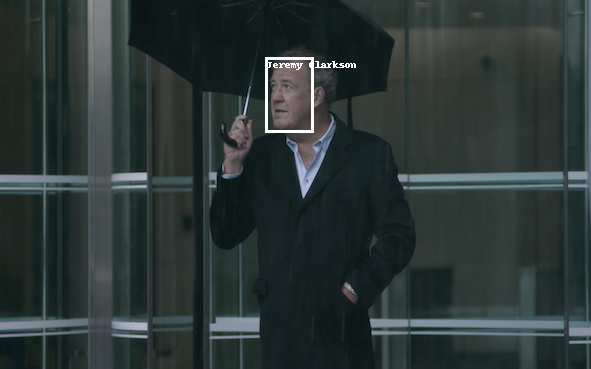

In [17]:
# Extract bounding box information from JSON response above and display image with bounding boxes around celebrites.

boxes = []
celebrities = recognizeCelebritiesResponse['CelebrityFaces']
for celebrity in celebrities:
    boxes.append ((celebrity['Name'], celebrity['Face']['BoundingBox']))
    
drawBoundingBoxes(imageName, boxes)

# Content moderation in Images
***

In [18]:
imageName = "media/content-moderation/yoga_swimwear_resized.jpg"

#### Call Rekognition to detect objects in the image

In [19]:
# Call Amazon Rekognition to detect unsafe content in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/moderation.html

detectModerationLabelsResponse = rekognition.detect_moderation_labels(
   Image={
       'S3Object': {
           'Bucket': bucketName,
           'Name': imageName,
       }
   }
)

In [20]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

#### Review the raw JSON reponse from Rekognition

In [21]:
# Show JSON response returned by Rekognition Moderation API
# In the JSON response below, you will see Moderation Labels, confidence score and additional information.

display(detectModerationLabelsResponse)

{'ModerationLabels': [{'Confidence': 96.8208999633789,
   'Name': 'Suggestive',
   'ParentName': ''},
  {'Confidence': 96.8208999633789,
   'Name': 'Female Swimwear Or Underwear',
   'ParentName': 'Suggestive'},
  {'Confidence': 72.2499008178711,
   'Name': 'Revealing Clothes',
   'ParentName': 'Suggestive'}],
 'ModerationModelVersion': '5.0',
 'ResponseMetadata': {'RequestId': '3704fcf6-4c56-4205-b6b4-5a38e4e36e33',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3704fcf6-4c56-4205-b6b4-5a38e4e36e33',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '302',
   'date': 'Mon, 08 Nov 2021 03:51:58 GMT'},
  'RetryAttempts': 0}}

#### Display list of detected moderation labels

In [22]:
for label in detectModerationLabelsResponse["ModerationLabels"]:
    print("- {} (Confidence: {})".format(label["Name"], label["Confidence"]))
    print("  - Parent: {}".format(label["ParentName"]))

- Suggestive (Confidence: 96.8208999633789)
  - Parent: 
- Female Swimwear Or Underwear (Confidence: 96.8208999633789)
  - Parent: Suggestive
- Revealing Clothes (Confidence: 72.2499008178711)
  - Parent: Suggestive


# Text Detection
***

### Set the image used for text detection

In [65]:
imageName = "media/text-detection/blender_tearsofsteel.jpg"

### View the image submitting to Rekognition

In [66]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

### Call Rekognition to detect text

In [67]:
# Call Amazon Rekognition to detect unsafe content in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/moderation.html

detectTextResponse = rekognition.detect_text(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    },
)

### View Results

In [68]:
display(detectTextResponse)

{'TextDetections': [{'DetectedText': 'CLOUD.BLENDER.ORG/SPRING',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 98.83615112304688,
   'Geometry': {'BoundingBox': {'Width': 0.3271351158618927,
     'Height': 0.04272352159023285,
     'Left': 0.33758440613746643,
     'Top': 0.41255006194114685},
    'Polygon': [{'X': 0.33758440613746643, 'Y': 0.4138851761817932},
     {'X': 0.6646661758422852, 'Y': 0.41255006194114685},
     {'X': 0.6647195219993591, 'Y': 0.45393848419189453},
     {'X': 0.337637722492218, 'Y': 0.4552735984325409}]}},
  {'DetectedText': 'Licensed as Creative Commons Attribution 4.0',
   'Type': 'LINE',
   'Id': 1,
   'Confidence': 99.82762908935547,
   'Geometry': {'BoundingBox': {'Width': 0.36465510725975037,
     'Height': 0.03614857420325279,
     'Left': 0.315046489238739,
     'Top': 0.4622182548046112},
    'Polygon': [{'X': 0.3150811493396759, 'Y': 0.4622182548046112},
     {'X': 0.679701566696167, 'Y': 0.4633621573448181},
     {'X': 0.6796669363975525, 'Y': 0.

### View the detected text

In [30]:
for text in detectTextResponse["TextDetections"]:
    print("- {} (Confidence: {})".format(text["DetectedText"], text["Confidence"]))

- CLOUD.BLENDER.ORG/SPRING (Confidence: 98.83615112304688)
- Licensed as Creative Commons Attribution 4.0 (Confidence: 99.82769775390625)
- G Blender Cloud blender (Confidence: 96.96292877197266)
- CLOUD.BLENDER.ORG/SPRING (Confidence: 98.83615112304688)
- Licensed (Confidence: 100.0)
- as (Confidence: 99.92317199707031)
- Creative (Confidence: 100.0)
- Commons (Confidence: 100.0)
- Attribution (Confidence: 99.60958099365234)
- 4.0 (Confidence: 99.43342590332031)
- G (Confidence: 87.95170593261719)
- Blender (Confidence: 100.0)
- Cloud (Confidence: 100.0)
- blender (Confidence: 99.9000015258789)


# Face Detection
***

### Set image for face detection

In [70]:
imageName = "media/face-detection/face-detection.jpg"

### View the image that's being submitted

### Submit face detection

In [71]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

In [72]:
detectFacesResponse = rekognition.detect_faces(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    },
    Attributes=[
        'ALL',
    ]
)

### View results

In [73]:
display(detectFacesResponse)

{'FaceDetails': [{'BoundingBox': {'Width': 0.22967946529388428,
    'Height': 0.4073323607444763,
    'Left': 0.4774216115474701,
    'Top': 0.1821325123310089},
   'AgeRange': {'Low': 22, 'High': 34},
   'Smile': {'Value': True, 'Confidence': 99.66121673583984},
   'Eyeglasses': {'Value': True, 'Confidence': 99.71788787841797},
   'Sunglasses': {'Value': False, 'Confidence': 98.5967025756836},
   'Gender': {'Value': 'Male', 'Confidence': 75.83314514160156},
   'Beard': {'Value': False, 'Confidence': 92.60050964355469},
   'Mustache': {'Value': False, 'Confidence': 98.27436065673828},
   'EyesOpen': {'Value': True, 'Confidence': 99.94817352294922},
   'MouthOpen': {'Value': True, 'Confidence': 99.33152770996094},
   'Emotions': [{'Type': 'HAPPY', 'Confidence': 99.31075286865234},
    {'Type': 'DISGUSTED', 'Confidence': 0.20410944521427155},
    {'Type': 'SURPRISED', 'Confidence': 0.15742264688014984},
    {'Type': 'CONFUSED', 'Confidence': 0.11716756224632263},
    {'Type': 'CALM', 'Co

# Face Collections
***

### Set the name of your collection id

In [31]:
collectionName = "M2C-GPS304-Face-Collection"

### Create face collection  

In [32]:
createCollectionResponse=rekognition.create_collection(CollectionId=collectionName)

ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateCollection operation: The collection id: M2C-GPS304-Face-Collection already exists

### View the results of your face collection

In [33]:
print (createCollectionResponse)

NameError: name 'createCollectionResponse' is not defined

### Crate a face in the collection

In [75]:
# Set the image name used to submit to the face collection
imageName = "media/face-collection/face1a.jpeg"
fileName = os.path.basename(imageName)

faceIndexResponse=rekognition.index_faces(
                    CollectionId=collectionName,
                    Image={
                        'S3Object':{
                            'Bucket':bucketName,
                            'Name':imageName
                            }
                        },
                    ExternalImageId=os.path.splitext(fileName)[0],
                    MaxFaces=1,
                    QualityFilter="AUTO",
                    DetectionAttributes=['ALL']
                    )

### View the response for indexing the face

In [76]:
display(faceIndexResponse)

{'FaceRecords': [{'Face': {'FaceId': 'a7e0336d-bb78-4abe-9ef1-f6b424820b0b',
    'BoundingBox': {'Width': 0.1748030185699463,
     'Height': 0.3262081444263458,
     'Left': 0.41659289598464966,
     'Top': 0.043345335870981216},
    'ImageId': '862763dc-6d30-394e-b6ec-634e306c0b95',
    'ExternalImageId': 'face1a',
    'Confidence': 99.99915313720703},
   'FaceDetail': {'BoundingBox': {'Width': 0.1748030185699463,
     'Height': 0.3262081444263458,
     'Left': 0.41659289598464966,
     'Top': 0.043345335870981216},
    'AgeRange': {'Low': 24, 'High': 38},
    'Smile': {'Value': False, 'Confidence': 91.27635955810547},
    'Eyeglasses': {'Value': False, 'Confidence': 94.1491470336914},
    'Sunglasses': {'Value': False, 'Confidence': 98.05127716064453},
    'Gender': {'Value': 'Male', 'Confidence': 94.32988739013672},
    'Beard': {'Value': True, 'Confidence': 62.373687744140625},
    'Mustache': {'Value': False, 'Confidence': 89.80272674560547},
    'EyesOpen': {'Value': True, 'Confi

#### Set face images to upload to collection

In [85]:
faces = [
    'media/face-collection/face2.jpg',
    'media/face-collection/face3.jpg',
    'media/face-collection/face4.jpg',
    'media/face-collection/face5.jpg',
    'media/face-collection/face6.jpg'
    ]

### Upload faces to face collection

In [86]:
for face in faces:
    fileName = os.path.basename(face)
    faceIndexResponse=rekognition.index_faces(
                    CollectionId=collectionName,
                    Image={
                        'S3Object':{
                            'Bucket':bucketName,
                            'Name':face
                            }
                        },
                    ExternalImageId=os.path.splitext(fileName)[0],
                    MaxFaces=1,
                    QualityFilter="AUTO",
                    DetectionAttributes=['ALL']
                    )

### View faces in face collection

In [87]:
listFacesResponse = rekognition.list_faces(
    CollectionId=collectionName,
)

### Review raw JSON results

In [88]:
display(listFacesResponse)

{'Faces': [{'FaceId': '52c44f24-321e-49a8-b463-d84f0a240d09',
   'BoundingBox': {'Width': 0.14028699696063995,
    'Height': 0.2661750018596649,
    'Left': 0.41133299469947815,
    'Top': 0.2359980046749115},
   'ImageId': 'b1ff669b-8c9f-3f94-be16-0fc50455eca9',
   'ExternalImageId': 'face4',
   'Confidence': 99.9979019165039},
  {'FaceId': '64562a73-1d4e-4a78-b627-75d13ef7e76a',
   'BoundingBox': {'Width': 0.09536559879779816,
    'Height': 0.1874690055847168,
    'Left': 0.3303210139274597,
    'Top': 0.11409500241279602},
   'ImageId': 'd25f3d88-3eb1-3f20-bcbf-277585b5f3e8',
   'ExternalImageId': 'face3',
   'Confidence': 99.9854965209961},
  {'FaceId': '716964d6-ad3b-449b-b319-7d95cf391b74',
   'BoundingBox': {'Width': 0.11123500019311905,
    'Height': 0.2281000018119812,
    'Left': 0.46771299839019775,
    'Top': 0.2082030028104782},
   'ImageId': '6dc37085-ffce-3e09-821c-35b241dae04d',
   'ExternalImageId': 'face6',
   'Confidence': 99.997802734375},
  {'FaceId': '8519364c-d4f

### Search for a face in the face collection

In [80]:
imageName = "media/face-collection/face1b.jpeg"

### View image

In [81]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

### Search for similar face 

In [82]:
searchFacesByImageResponse = rekognition.search_faces_by_image(
    CollectionId=collectionName,
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    },
)

### View results

In [83]:
display(searchFacesByImageResponse)

{'SearchedFaceBoundingBox': {'Width': 0.25413447618484497,
  'Height': 0.5494118332862854,
  'Left': 0.37787485122680664,
  'Top': 0.1308797001838684},
 'SearchedFaceConfidence': 99.998046875,
 'FaceMatches': [{'Similarity': 99.99972534179688,
   'Face': {'FaceId': 'a7e0336d-bb78-4abe-9ef1-f6b424820b0b',
    'BoundingBox': {'Width': 0.1748030036687851,
     'Height': 0.3262079954147339,
     'Left': 0.4165929853916168,
     'Top': 0.04334529861807823},
    'ImageId': '862763dc-6d30-394e-b6ec-634e306c0b95',
    'ExternalImageId': 'face1a',
    'Confidence': 99.99919891357422}}],
 'FaceModelVersion': '5.0',
 'ResponseMetadata': {'RequestId': 'd9e3b05e-e0d3-474f-96be-a06289580188',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd9e3b05e-e0d3-474f-96be-a06289580188',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '536',
   'date': 'Mon, 08 Nov 2021 05:48:40 GMT'},
  'RetryAttempts': 0}}

### face detection stuff

In [ ]:
# Face detection code

detectFacesResponse = client.detect_faces(
    Image={
        'Bytes': b'bytes',
        'S3Object': {
            'Bucket': 'string',
            'Name': 'string',
            'Version': 'string'
        }
    },
    Attributes=[
        'DEFAULT'|'ALL',
    ]
)

### View results of face detection

In [ ]:
print('detectFacesResponse')